<h>Imports</h>

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load('../data/processed/train_val_test.pkl')

<h>Functions</h>

In [4]:
def calculate_show_metrics(classifier, classifier_description, X_val, y_val):
    y_pred_val = classifier.predict(X_val)

    # metrics
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val, average='binary')
    val_recall = recall_score(y_val, y_pred_val, average='binary')
    val_f1 = f1_score(y_val, y_pred_val, average='binary')

    print(f'{classifier_description}:')
    print(f' Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
    print(f' Accuracy: {val_accuracy:.4f}')
    print('')
    print(classification_report(y_val, y_pred_val))
    cm = confusion_matrix(y_val, y_pred_val)
    print(cm)
    return val_accuracy, val_precision, val_recall, val_f1

def calculate_show_roc_auc(classifier, classifier_description, X_val, y_val):
    # Get predicted probabilities for validation set
    y_pred_proba_val = classifier.predict_proba(X_val)[:, 1]

    # Calculate ROC curve for validation set
    fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_proba_val)

    # Calculate AUC for validation set
    roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

    # Plot ROC curve for validation set
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_description}: Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc_val

<h>LogisticRegression</h>

In [5]:
lr_classifier = LogisticRegression(random_state=777, max_iter=100000)

lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=100000, random_state=777)

In [6]:
calculate_show_metrics(lr_classifier, 'LR classifier Validation', X_val, y_val)

LR classifier Validation:
 Precision: 0.6772, Recall: 0.2019, F1 Score: 0.3110
 Accuracy: 0.8095

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1574
           1       0.68      0.20      0.31       426

    accuracy                           0.81      2000
   macro avg       0.75      0.59      0.60      2000
weighted avg       0.79      0.81      0.77      2000

[[1533   41]
 [ 340   86]]


(0.8095, 0.6771653543307087, 0.20187793427230047, 0.31103074141048825)

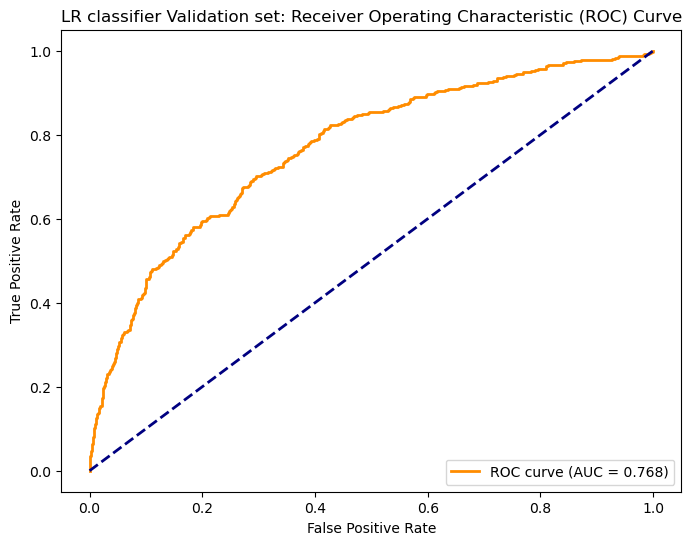

0.7679710196801308

In [7]:
calculate_show_roc_auc(lr_classifier, 'LR classifier Validation set', X_val, y_val)

<h>Hyper Parameter Tuning</h>

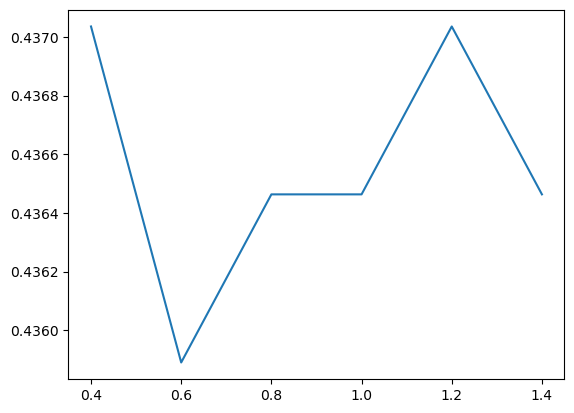

In [8]:
scores = []
for C in [0.4, 0.6, 0.8, 1.0, 1.2, 1.4]:
        lr = LogisticRegression(C=C, random_state=777, max_iter=100000)
        model = lr.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred_val)
        scores.append((C, rmse))

df_scores = pd.DataFrame(scores, columns=['C', 'rmse'])
plt.plot(df_scores.C, df_scores.rmse)
plt.show()


LR classifier Tuned Test:
 Precision: 0.6033, Recall: 0.1886, F1 Score: 0.2874
 Accuracy: 0.8190

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1613
           1       0.60      0.19      0.29       387

    accuracy                           0.82      2000
   macro avg       0.72      0.58      0.59      2000
weighted avg       0.79      0.82      0.78      2000

[[1565   48]
 [ 314   73]]


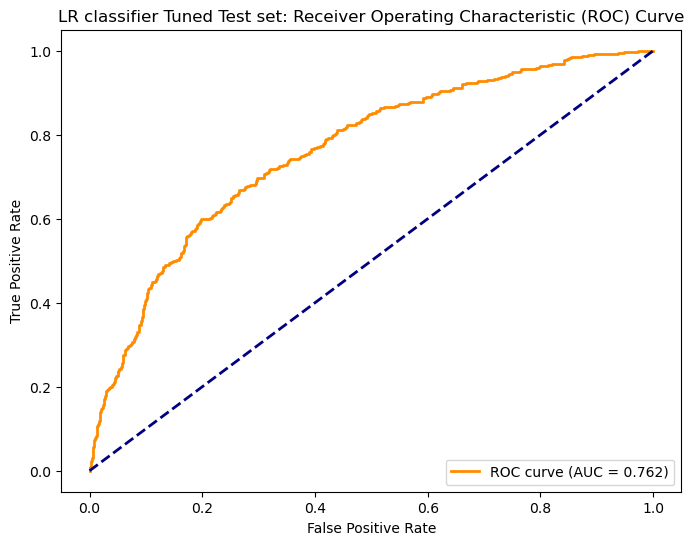

0.7619006425505942

In [9]:
lr_classifier_tuned = LogisticRegression(C=0.6, random_state=777, max_iter=100000)
lr_classifier_tuned.fit(X_train, y_train)
calculate_show_metrics(lr_classifier_tuned, 'LR classifier Tuned Test', X_test, y_test)
calculate_show_roc_auc(lr_classifier_tuned, 'LR classifier Tuned Test set', X_test, y_test)

In [10]:
lr_accuracy, lr_precision, lr_recall, lr_f1 = calculate_show_metrics(lr_classifier, 'LR classifier Test', X_test, y_test)

LR classifier Test:
 Precision: 0.5854, Recall: 0.1860, F1 Score: 0.2824
 Accuracy: 0.8170

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1613
           1       0.59      0.19      0.28       387

    accuracy                           0.82      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.82      0.78      2000

[[1562   51]
 [ 315   72]]


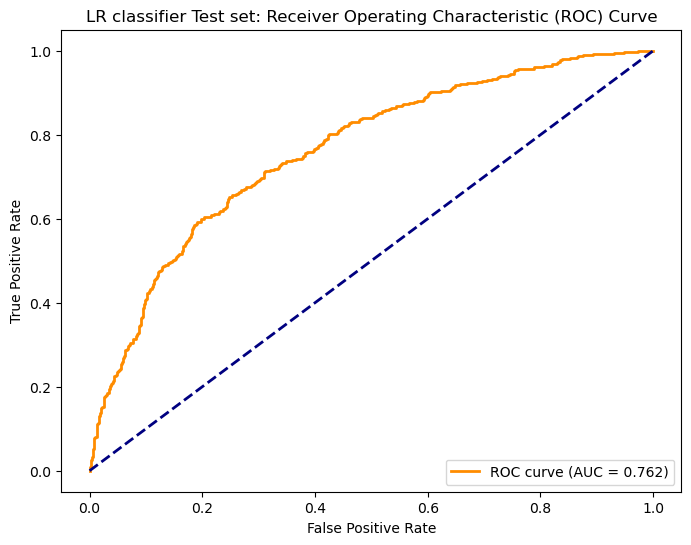

In [11]:
lr_roc_auc = calculate_show_roc_auc(lr_classifier, 'LR classifier Test set', X_test, y_test)

<h>RandomForest</h>

In [12]:
rf_classifier = RandomForestClassifier(random_state=777, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=777)

In [13]:
calculate_show_metrics(rf_classifier, 'RF classifier Validation', X_val, y_val)

RF classifier Validation:
 Precision: 0.7628, Recall: 0.4531, F1 Score: 0.5685
 Accuracy: 0.8535

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1574
           1       0.76      0.45      0.57       426

    accuracy                           0.85      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000

[[1514   60]
 [ 233  193]]


(0.8535, 0.7628458498023716, 0.45305164319248825, 0.5684830633284241)

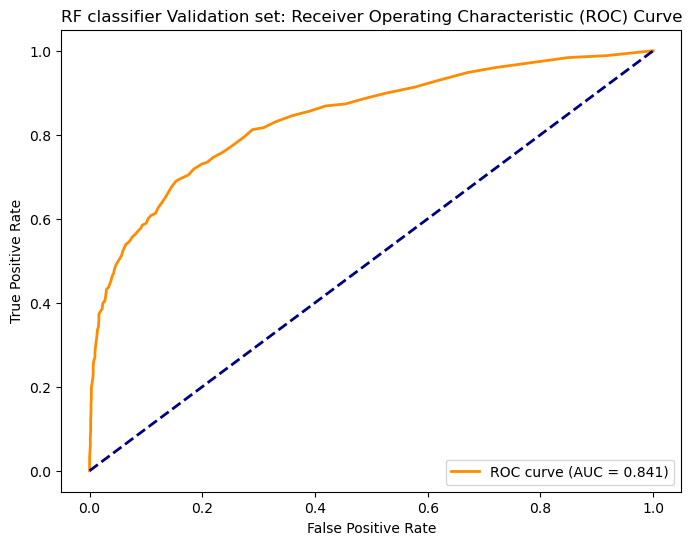

0.8405545513657976

In [14]:
calculate_show_roc_auc(rf_classifier, 'RF classifier Validation set', X_val, y_val)

<h>Hyper Parameters Tuning</h>

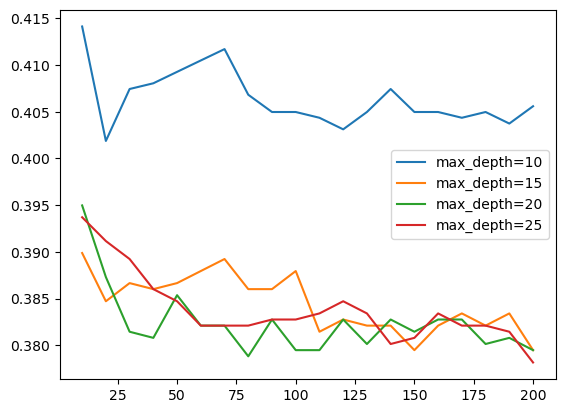

In [15]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, random_state=777, n_jobs=1, max_depth=d, class_weight='balanced')
        model = rf.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred_val)
        scores.append((d, n, rmse))
        # print(d, n, round(rmse, 4))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth={d}')

plt.legend()
plt.show()

In [16]:
d = 15
n = 110
rf = RandomForestClassifier(n_estimators=n, random_state=777, n_jobs=1, max_depth=d, class_weight='balanced')
model = rf.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred_val)
scores.append((d, n, rmse))
print(d, n, round(rmse, 3))

calculate_show_metrics(model, f'RF classifier Tuned {d} {n}', X_val, y_val)

15 110 0.381
RF classifier Tuned 15 110:
 Precision: 0.7455, Recall: 0.4812, F1 Score: 0.5849
 Accuracy: 0.8545

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1574
           1       0.75      0.48      0.58       426

    accuracy                           0.85      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.84      0.85      0.84      2000

[[1504   70]
 [ 221  205]]


(0.8545, 0.7454545454545455, 0.4812206572769953, 0.5848787446504993)

In [17]:
calculate_show_metrics(model, f'RF classifier tuned Test', X_test, y_test)

RF classifier tuned Test:
 Precision: 0.7128, Recall: 0.5194, F1 Score: 0.6009
 Accuracy: 0.8665

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1613
           1       0.71      0.52      0.60       387

    accuracy                           0.87      2000
   macro avg       0.80      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

[[1532   81]
 [ 186  201]]


(0.8665, 0.7127659574468085, 0.5193798449612403, 0.600896860986547)

In [18]:
rf_accuracy, rf_precision, rf_recall, rf_f1 = calculate_show_metrics(rf_classifier, f'RF classifier Test', X_test, y_test)

RF classifier Test:
 Precision: 0.7510, Recall: 0.4987, F1 Score: 0.5994
 Accuracy: 0.8710

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1613
           1       0.75      0.50      0.60       387

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

[[1549   64]
 [ 194  193]]


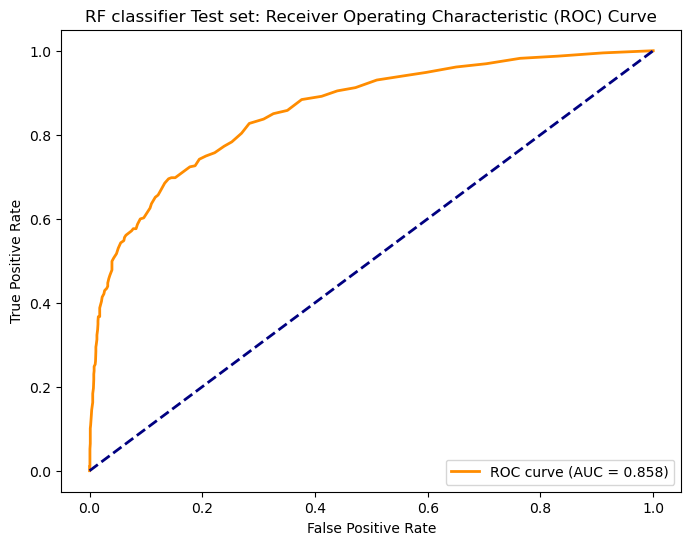

In [19]:
rf_roc_auc = calculate_show_roc_auc(rf_classifier, 'RF classifier Test set', X_test, y_test)

<h>AdaBOOST</h>

In [20]:
ada_classifier = AdaBoostClassifier(algorithm='SAMME.R', random_state=777)

ada_classifier.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=777)

In [21]:
calculate_show_metrics(ada_classifier, 'Ada classifier Validation', X_val, y_val)

Ada classifier Validation:
 Precision: 0.7319, Recall: 0.4742, F1 Score: 0.5755
 Accuracy: 0.8510

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1574
           1       0.73      0.47      0.58       426

    accuracy                           0.85      2000
   macro avg       0.80      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000

[[1500   74]
 [ 224  202]]


(0.851, 0.7318840579710145, 0.47417840375586856, 0.5754985754985755)

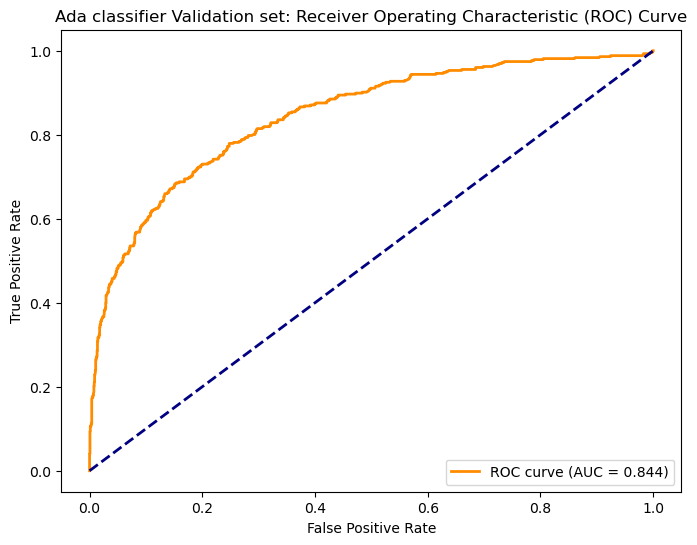

0.8441651603820296

In [22]:
calculate_show_roc_auc(ada_classifier, 'Ada classifier Validation set', X_val, y_val)

In [23]:
ada_accuracy, ada_precision, ada_recall, ada_f1 = calculate_show_metrics(ada_classifier, f'Ada classifier Test', X_test, y_test)

Ada classifier Test:
 Precision: 0.6796, Recall: 0.4987, F1 Score: 0.5753
 Accuracy: 0.8575

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1613
           1       0.68      0.50      0.58       387

    accuracy                           0.86      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.85      0.86      0.85      2000

[[1522   91]
 [ 194  193]]


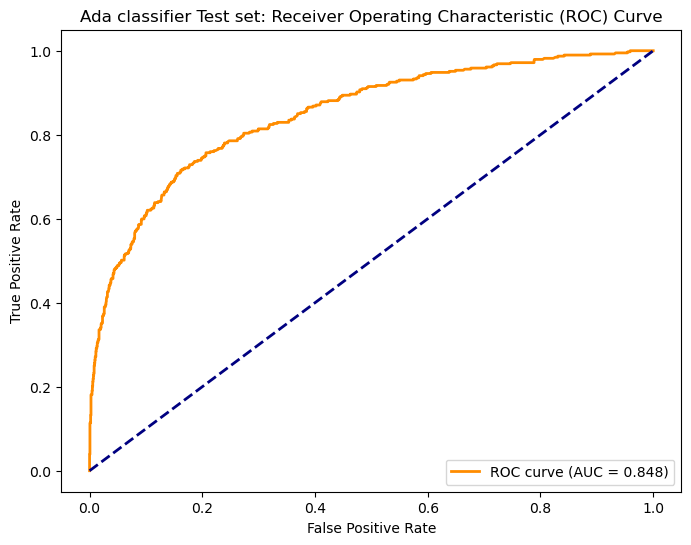

In [24]:
ada_roc_auc = calculate_show_roc_auc(ada_classifier, 'Ada classifier Test set', X_test, y_test)

<h>XGBoost</h>

In [25]:
xgb_classifier = XGBClassifier(random_state=777)

xgb_classifier.fit(X_train, y_train)

calculate_show_metrics(xgb_classifier, 'RF classifier Validation', X_val, y_val)

RF classifier Validation:
 Precision: 0.6852, Recall: 0.4906, F1 Score: 0.5718
 Accuracy: 0.8435

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1574
           1       0.69      0.49      0.57       426

    accuracy                           0.84      2000
   macro avg       0.78      0.71      0.74      2000
weighted avg       0.83      0.84      0.83      2000

[[1478   96]
 [ 217  209]]


(0.8435, 0.6852459016393443, 0.49061032863849763, 0.5718194254445964)

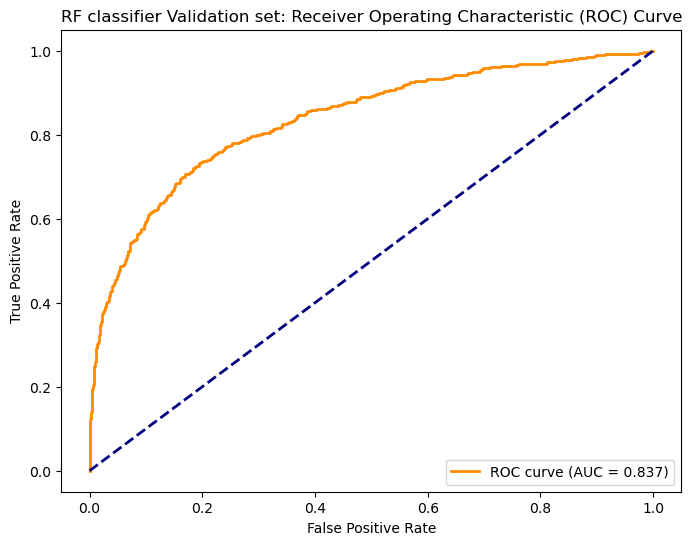

0.8373958277406923

In [26]:
calculate_show_roc_auc(xgb_classifier, 'RF classifier Validation set', X_val, y_val)

<h>Hyper Parameters Tuning</h>

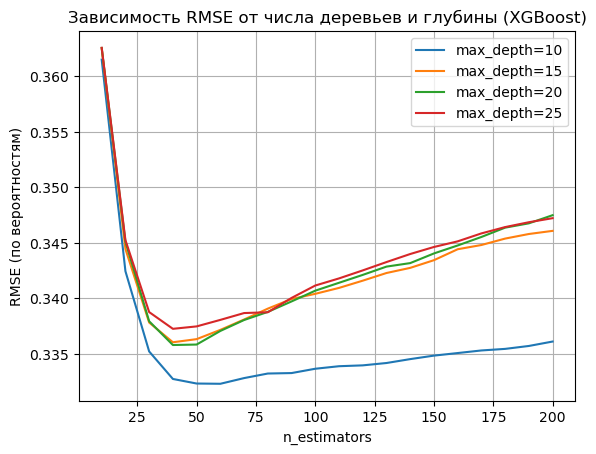

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import root_mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        xgb = XGBClassifier(
            n_estimators=n,
            max_depth=d,
            learning_rate=0.05,
            eval_metric='logloss',
            random_state=777
        )
        model = xgb.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        rmse = root_mean_squared_error(y_val, y_pred_proba)
        scores.append((d, n, rmse))

# Визуализация
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth={d}')

plt.xlabel("n_estimators")
plt.ylabel("RMSE (по вероятностям)")
plt.title("Зависимость RMSE от числа деревьев и глубины (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
d = 10
n = 50
xgb = XGBClassifier(n_estimators=n, random_state=777, max_depth=d)
model = xgb.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred_val)
scores.append((d, n, rmse))
print(d, n, round(rmse, 3))

calculate_show_metrics(model, f'XGB classifier Tuned {d} {n}', X_val, y_val)

10 50 0.394
XGB classifier Tuned 10 50:
 Precision: 0.6871, Recall: 0.5000, F1 Score: 0.5788
 Accuracy: 0.8450

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1574
           1       0.69      0.50      0.58       426

    accuracy                           0.84      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.83      0.84      0.84      2000

[[1477   97]
 [ 213  213]]


(0.845, 0.6870967741935484, 0.5, 0.5788043478260869)

In [29]:
calculate_show_metrics(model, f'XGB classifier tuned Test', X_test, y_test)

XGB classifier tuned Test:
 Precision: 0.6689, Recall: 0.5168, F1 Score: 0.5831
 Accuracy: 0.8570

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1613
           1       0.67      0.52      0.58       387

    accuracy                           0.86      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.85      0.86      0.85      2000

[[1514   99]
 [ 187  200]]


(0.857, 0.6688963210702341, 0.5167958656330749, 0.5830903790087464)

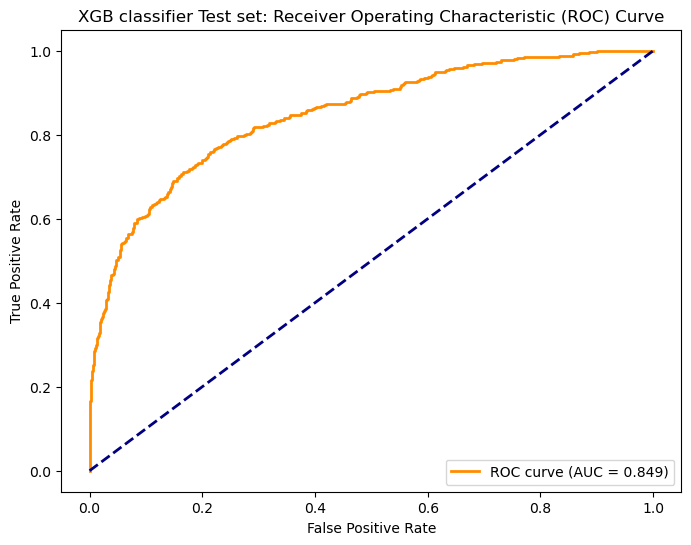

In [30]:
xgb_roc_auc = calculate_show_roc_auc(xgb_classifier, 'XGB classifier Test set', X_test, y_test)

In [31]:
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = calculate_show_metrics(ada_classifier, f'XGB classifier Test', X_test, y_test)

XGB classifier Test:
 Precision: 0.6796, Recall: 0.4987, F1 Score: 0.5753
 Accuracy: 0.8575

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1613
           1       0.68      0.50      0.58       387

    accuracy                           0.86      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.85      0.86      0.85      2000

[[1522   91]
 [ 194  193]]


<h>Final comparison of metrics</h>

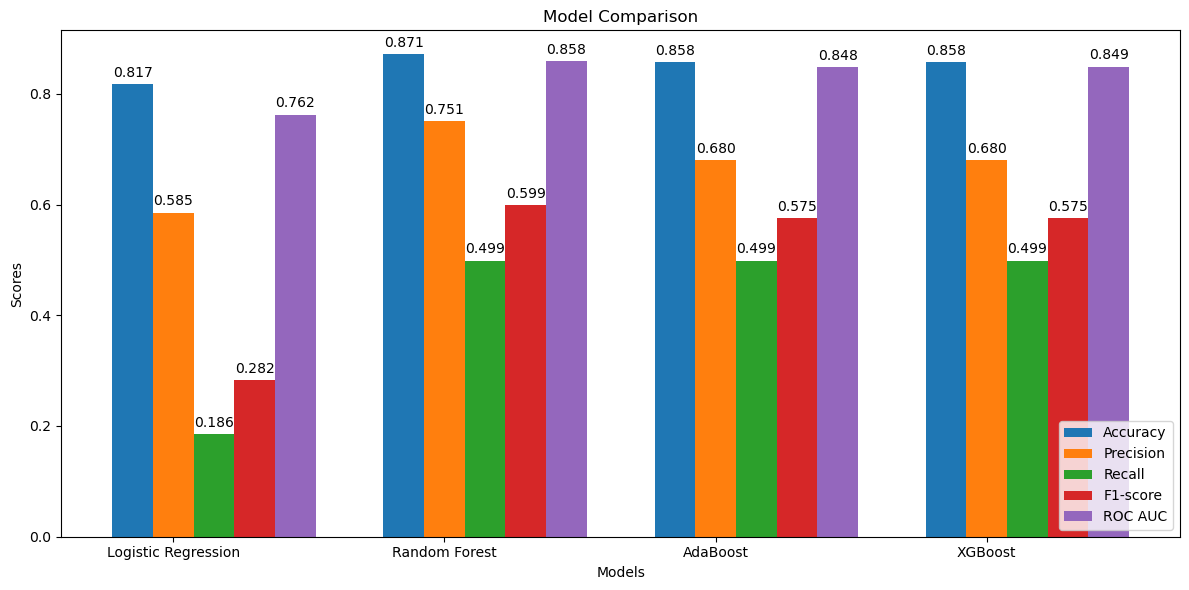

In [32]:
# Data for the bar chart
models = ['Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost']
final_accuracy = [lr_accuracy, rf_accuracy, ada_accuracy, xgb_accuracy ]
final_precision = [lr_precision, rf_precision, ada_precision, xgb_precision]
final_recall = [lr_recall, rf_recall, ada_recall, xgb_recall]
final_f1_score = [lr_f1, rf_f1, ada_f1, xgb_f1]
final_roc_auc = [lr_roc_auc, rf_roc_auc, ada_roc_auc, xgb_roc_auc]

bar_width = 0.15

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(r1, final_accuracy, bar_width, label='Accuracy')
bars2 = ax.bar(r2, final_precision, bar_width, label='Precision')
bars3 = ax.bar(r3, final_recall, bar_width, label='Recall')
bars4 = ax.bar(r4, final_f1_score, bar_width, label='F1-score')
bars5 = ax.bar(r5, final_roc_auc, bar_width, label='ROC AUC')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks([r + bar_width for r in range(len(models))])
ax.set_xticklabels(models)
ax.legend(loc='lower right')

# Add value labels on top of bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
autolabel(bars4)
autolabel(bars5)

# Display the chart
plt.tight_layout()
plt.show()

In [33]:
joblib.dump(rf, '../models/model.pkl')

['../models/model.pkl']